In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import seaborn as sns
import pyarrow


from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
def sample_n_visitors (full, n):
    uniqueid = full["visitid"].unique().to_pandas()
    sample_nid = pa.array(uniqueid.sample(n))
    id_filter_idx = pc.is_in(full["visitid"], sample_nid)
    full_filtered = full.filter(id_filter_idx)
    return full_filtered

def read_full_week (cols, direc):
    week_dic = {}
    fileidx = np.arange(10, 17)
    for i in range(len(fileidx)):
        print('read: ' + direc + 'visitday=' + str(fileidx[i]))
        dataset = pq.ParquetDataset('Math-M148-data-january2023/hitdata7days/visitday=' + str(fileidx[i]))
        week_dic['visitday=' + str(fileidx[i])] = dataset.read(columns = cols)
    
    full_week = pd.DataFrame([],
                   columns=cols)
    for i in week_dic:
        full_week=pd.concat([full_week,week_dic[i].to_pandas()])

    return full_week

def add_newfeature(full_week,col):
    visit_week = read_full_week(col, 'week/')
    new_feature = pd.DataFrame([],
                   columns=col)
    
    for i in visit_week:
        new_feature=pd.concat([new_feature,visit_week[i].to_pandas()])
    full_week[col] = new_feature
    
    return full_week

In [178]:
col = ['visitid','devicetype','promocode','evar83','eVar82','ordernumber']
visit_week = read_full_week(col, 'week/')

read: week/visitday=10
read: week/visitday=11
read: week/visitday=12
read: week/visitday=13
read: week/visitday=14
read: week/visitday=15
read: week/visitday=16


In [179]:
a= visit_week.groupby(['visitid']).first()

In [46]:
%time
def bin_behavior(x):
    if not x:
        return 'Unknown'
    else:
        if int(x)>495:
            return '495-562'
        elif int(x)>428:
            return '428-495'
        elif int(x)>361:
            return '361-428'
        else:
            return '294-361'
        
    
a["behavior_score"] = a["evar83"].apply(bin_behavior)
%time

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 12.2 µs
CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [180]:
a['promocode'] = ~a['promocode'].isna()

a['eVar82'] = ~a['eVar82'].isna()
a['order'] = ~a['ordernumber'].isna()

In [181]:
test = a[['promocode','eVar82','order']]

In [182]:
test.reset_index()

,visitid,promocode,eVar82,order
0,001,False,False,False
1,0010,False,False,False
2,00100,False,False,False
3,00101,False,False,False
4,00102,False,False,False
...,...,...,...,...
2041281,99997363407775132790292379433452812751,False,False,False
2041282,99998319783911559758692653866775905231,False,False,False
2041283,99999087067885636914464571239461031391,False,False,False
2041284,99999155003421544234572785263257688231,False,False,False


In [187]:
a

,devicetype,promocode,evar83,eVar82,ordernumber,order
visitid,,,,,,
001,Tablet,False,,False,None,False
0010,Mobile,False,,False,None,False
00100,Desktop,False,,False,None,False
00101,Mobile,False,,False,None,False
00102,Mobile,False,,False,None,False
...,...,...,...,...,...,...
99997363407775132790292379433452812751,Desktop,False,None,False,None,False
99998319783911559758692653866775905231,Tablet,False,None,False,None,False
99999087067885636914464571239461031391,Tablet,False,None,False,None,False


In [184]:
p_t = test[test['promocode']==1]
p_t

,promocode,eVar82,order
visitid,,,
1000108257559953773562411289844339462981,True,False,True
100034118541581008486617653558704628597,True,False,True
100068898285134821927141456802434564309,True,False,True
10008266340795712901655509953153309891,True,False,True
10008266340795712901655509953153309892,True,False,True
...,...,...,...
99898932752452050033614126798257750096,True,False,True
99898932752452050033614126798257750097,True,False,True
99966830539311880448190947143702206652,True,False,True


In [49]:
dataset = pq.read_table('dataset_final.parquet')

In [50]:
#convert to dataframe
dataset = pyarrow.Table.to_pandas(dataset)

In [ ]:
# Add devicetype into Dataset 

In [51]:
dataset=dataset.join(a, on='visitid', how='left')

In [52]:
dataset

,visitid,newvisit,pg_cat,timedelta,session_time,pg_count,sum_cart,prod_in_cart,avg_cart,min_cart,...,sum_prod,prod_viewed,avg_prod,min_prod,max_prod,ordernumber_full,devicetype,promocode,evar83,behavior_score
0,001,0,pdp,0.0,0.0,0,0.0,0,0.0,0.0,...,0.00,0,0.00,0.00,0.00,False,Tablet,False,,Unknown
1,001,0,search,2062.0,2062.0,1,0.0,0,0.0,0.0,...,0.00,0,0.00,0.00,0.00,False,Tablet,False,,Unknown
2,001,0,search,227.0,2289.0,2,0.0,0,0.0,0.0,...,0.00,0,0.00,0.00,0.00,False,Tablet,False,,Unknown
3,001,0,search,95.0,2384.0,3,0.0,0,0.0,0.0,...,0.00,0,0.00,0.00,0.00,False,Tablet,False,,Unknown
4,001,0,search,75.0,2459.0,4,0.0,0,0.0,0.0,...,0.00,0,0.00,0.00,0.00,False,Tablet,False,,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458604,999838842448347828201007282656244896618,1,pdp,0.0,0.0,0,0.0,0,0.0,0.0,...,169.99,1,169.99,169.99,169.99,False,Tablet,False,None,Unknown
6458605,99997363407775132790292379433452812751,1,pdp,0.0,0.0,0,0.0,0,0.0,0.0,...,0.00,0,0.00,0.00,0.00,False,Desktop,False,None,Unknown
6458606,99997363407775132790292379433452812751,0,pdp,19.0,19.0,1,0.0,0,0.0,0.0,...,0.00,0,0.00,0.00,0.00,False,Desktop,False,None,Unknown
6458607,99997363407775132790292379433452812751,0,pdp,10.0,29.0,2,0.0,0,0.0,0.0,...,0.00,0,0.00,0.00,0.00,False,Desktop,False,None,Unknown


In [123]:
from sklearn import linear_model
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dataset['pg_cat']= le.fit_transform(dataset['pg_cat'])
dataset['devicetype']= le.fit_transform(dataset['devicetype'])
dataset['behavior_score']= le.fit_transform(dataset['behavior_score'])

<AxesSubplot:>

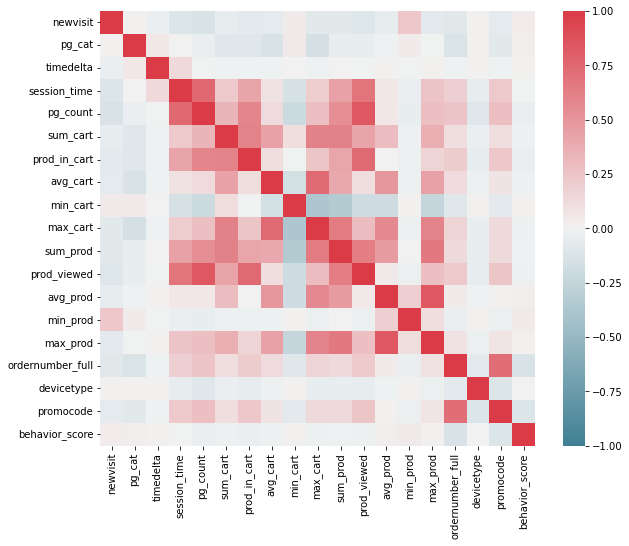

In [124]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

In [43]:
np.unique(dataset['pg_cat'])

array(['Cart_Interstitial', 'Clothing', 'Electronics', 'Shoes', 'cart',
       'checkout', 'index', 'mobile index', 'other', 'pdp', 'search'],
      dtype=object)

In [72]:
dataset.columns

Index(['visitid', 'newvisit', 'pg_cat', 'timedelta', 'session_time',
       'pg_count', 'sum_cart', 'prod_in_cart', 'avg_cart', 'min_cart',
       'max_cart', 'sum_prod', 'prod_viewed', 'avg_prod', 'min_prod',
       'max_prod', 'ordernumber_full', 'devicetype', 'promocode', 'evar83',
       'behavior_score'],
      dtype='object')

In [ ]:
one_hot_encoded_data.drop

# Encode 

In [54]:
one_hot_encoded_data = pd.get_dummies(dataset,columns=['pg_cat','devicetype','behavior_score'])
one_hot_encoded_data=one_hot_encoded_data.drop(columns=['evar83'])
one_hot_encoded_data.head()

,visitid,newvisit,timedelta,session_time,pg_count,sum_cart,prod_in_cart,avg_cart,min_cart,max_cart,...,pg_cat_search,devicetype_Desktop,devicetype_Mobile,devicetype_Tablet,devicetype_Unknown,behavior_score_294-361,behavior_score_361-428,behavior_score_428-495,behavior_score_495-562,behavior_score_Unknown
0,001,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
1,001,0,2062.0,2062.0,1,0.0,0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,1
2,001,0,227.0,2289.0,2,0.0,0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,1
3,001,0,95.0,2384.0,3,0.0,0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,1
4,001,0,75.0,2459.0,4,0.0,0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,1


In [98]:
one_hot_encoded_less660 = one_hot_encoded_data[one_hot_encoded_data['timedelta']<660]

In [99]:
# session time
session_time = one_hot_encoded_less660.groupby('visitid')['timedelta'].cumsum()

In [100]:
one_hot_encoded_less660['session_time']=session_time

/var/folders/xd/39vn4ttx5239g2gxfkr0tm_r0000gn/T/ipykernel_75926/3364421944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_hot_encoded_less660['session_time']=session_time


In [101]:
one_hot_encoded_less660

,visitid,newvisit,timedelta,session_time,pg_count,sum_cart,prod_in_cart,avg_cart,min_cart,max_cart,...,pg_cat_search,devicetype_Desktop,devicetype_Mobile,devicetype_Tablet,devicetype_Unknown,behavior_score_294-361,behavior_score_361-428,behavior_score_428-495,behavior_score_495-562,behavior_score_Unknown
0,001,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
2,001,0,227.0,227.0,2,0.0,0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,1
3,001,0,95.0,322.0,3,0.0,0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,1
4,001,0,75.0,397.0,4,0.0,0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,1
5,001,0,207.0,604.0,5,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6458604,999838842448347828201007282656244896618,1,0.0,0.0,0,0.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
6458605,99997363407775132790292379433452812751,1,0.0,0.0,0,0.0,0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
6458606,99997363407775132790292379433452812751,0,19.0,19.0,1,0.0,0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
6458607,99997363407775132790292379433452812751,0,10.0,29.0,2,0.0,0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [91]:
one_hot_encoded_data.columns

Index(['visitid', 'newvisit', 'timedelta', 'session_time', 'pg_count',
       'sum_cart', 'prod_in_cart', 'avg_cart', 'min_cart', 'max_cart',
       'sum_prod', 'prod_viewed', 'avg_prod', 'min_prod', 'max_prod',
       'ordernumber_full', 'pg_cat_Cart_Interstitial', 'pg_cat_Clothing',
       'pg_cat_Electronics', 'pg_cat_Shoes', 'pg_cat_cart', 'pg_cat_checkout',
       'pg_cat_index', 'pg_cat_mobile index', 'pg_cat_other', 'pg_cat_pdp',
       'pg_cat_search', 'devicetype_Desktop', 'devicetype_Mobile',
       'devicetype_Tablet', 'devicetype_Unknown'],
      dtype='object')

<AxesSubplot:>

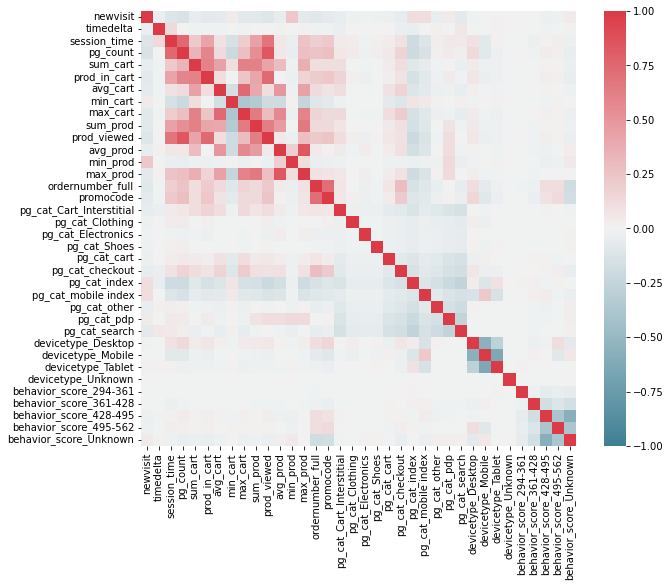

In [74]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = one_hot_encoded_data.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

# Split Data

In [ ]:
D = {}
for i in range(6458609):
    
    if one_hot_encoded_data['visitid'][i] in D:
        one_hot_encoded_data['newvisit'][i] =  D[one_hot_encoded_data['visitid'][i]]
    else:
        D[one_hot_encoded_data['visitid'][i]] = one_hot_encoded_data['newvisit'][i]


/var/folders/xd/39vn4ttx5239g2gxfkr0tm_r0000gn/T/ipykernel_75926/1280257828.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_hot_encoded_data['newvisit'][i] =  D[one_hot_encoded_data['visitid'][i]]


In [ ]:
one_hot_encoded_data

In [88]:
#for SVM and KNN
sampledata = one_hot_encoded_data.sample(frac = 0.01) 
data = sampledata.drop(["ordernumber_full", "visitid"], axis=1)
label = sampledata["ordernumber_full"].copy()

sX_train, sX_test, sy_train, sy_test = train_test_split(data, label, test_size=0.2)

print(sX_train.shape)
print(sy_train.shape)
print(sX_test.shape)
print(sy_test.shape)

(51668, 35)
(51668,)
(12918, 35)
(12918,)


In [102]:
data = one_hot_encoded_less660.drop(["ordernumber_full", "visitid"], axis=1)
label = one_hot_encoded_less660["ordernumber_full"].copy()

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5147536, 35)
(5147536,)
(1286885, 35)
(1286885,)


In [111]:
print(one_hot_encoded_less660.shape)
print(one_hot_encoded_data.shape)

(6434421, 37)
(6458609, 37)


In [ ]:
data = one_hot_encoded_data.drop(["ordernumber_full", "visitid"], axis=1)
label = one_hot_encoded_data["ordernumber_full"].copy()

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
ㄇprint(X_test.shape)
print(y_test.shape)

one_hot_encoded_less660

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

In [103]:
%%time
clf = RandomForestClassifier(random_state=0)

clf.fit(X_train, y_train)

predictions_rf = clf.predict(X_test)
%%time

UsageError: Line magic function `%%time` not found.


In [104]:
from sklearn import metrics

print("Final result for random forest:")
print('1. Accuracy:', metrics.accuracy_score(y_test, predictions_rf))
print('2. Precision:', metrics.precision_score(y_test, predictions_rf))
print('3. Recall:', metrics.recall_score(y_test, predictions_rf))
print('4. F1 Score:', metrics.f1_score(y_test, predictions_rf))

Final result for random forest:
1. Accuracy: 0.9623610501326847
2. Precision: 0.9800287627463867
3. Recall: 0.8768598818642049
4. F1 Score: 0.9255782866888429


/Users/yun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


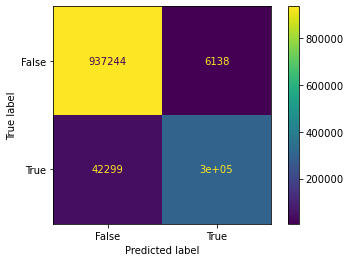

In [105]:
#from sklearn.metrics import plot_ddconfusion_matrix
plot_confusion_matrix(clf, X_test, y_test)

In [ ]:
 import matplotlib.pyplot as plt
import numpy as np
>>> from sklearn import metrics
>>> y = np.array([0, 0, 1, 1])
>>> pred = np.array([0.1, 0.4, 0.35, 0.8])
>>> fpr, tpr, thresholds = metrics.roc_curve(y, pred)
>>> roc_auc = metrics.auc(fpr, tpr)
>>> display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
...                                   estimator_name='example estimator')
>>> display.plot()
<...>
>>> plt.show()

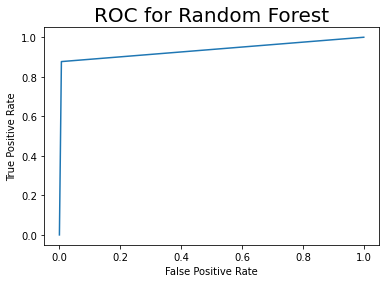

In [190]:
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = metrics.roc_curve(y_test,  predictions_rf)

#create ROC curve
plt.plot(fpr,tpr)

#display.plot()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC for Random Forest",fontsize=20)
plt.show()

Text(0, 0.5, 'Mean decrease in impurity')

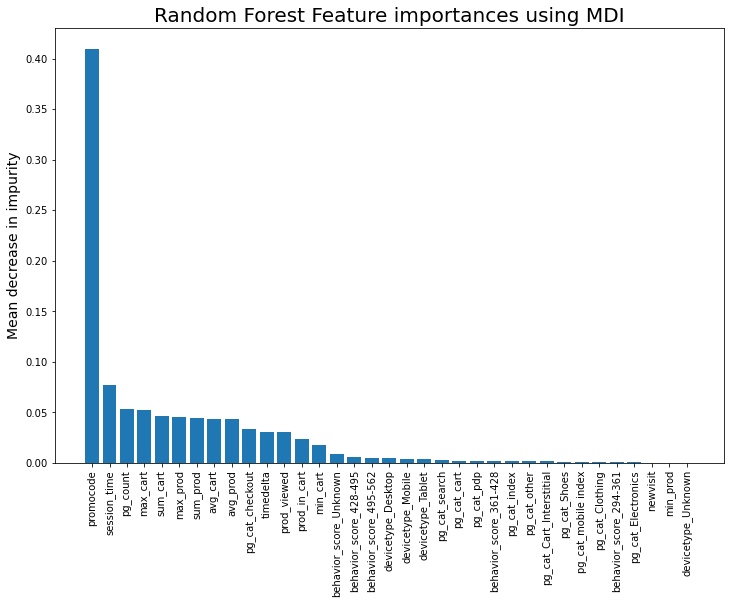

In [61]:
plt.figure(figsize=(12,8))
sorted_idx = clf.feature_importances_.argsort()[::-1]
plt.bar(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xticks(rotation=90)
plt.title("Random Forest Feature importances using MDI", fontsize=20)
plt.ylabel("Mean decrease in impurity", fontsize=14)


In [141]:
sum(y_train==0)

3772071

In [160]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = {0: 0.95,
                1: 0.05}
class_weights = compute_class_weight(class_weight = "balanced", classes =np.unique(y_train),y=y_train )
class_weights

array([0.68232226, 1.87119847])

In [166]:
from sklearn.linear_model  import LogisticRegression
log_incr = LogisticRegression(class_weight=class_weight)
#para = {"penalty": ("l1", "l2", "elasticnet")}
#clf_LR = GridSearchCV(log_incr, para, cv = 3)
log_incr.fit(X_train, y_train.values.ravel())

predictions_incr = log_incr.predict(X_test)
#clf_LR.best_estimator_


/Users/yun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [167]:
print('1. Accuracy:', metrics.accuracy_score(y_test, predictions_incr))
print('2. Precision:', metrics.precision_score(y_test, predictions_incr))
print('3. Recall:', metrics.recall_score(y_test, predictions_incr))
print('4. F1 Score:', metrics.f1_score(y_test, predictions_incr))

1. Accuracy: 0.7328828916336736
2. Precision: 0.4318936877076412
3. Recall: 0.002270722526440817
4. F1 Score: 0.004517692849013492


In [115]:
print('1. Accuracy:', metrics.accuracy_score(y_test, predictions_incr))
print('2. Precision:', metrics.precision_score(y_test, predictions_incr))
print('3. Recall:', metrics.recall_score(y_test, predictions_incr))
print('4. F1 Score:', metrics.f1_score(y_test, predictions_incr))

1. Accuracy: 0.7414081289314896
2. Precision: 0.5531387801615221
3. Recall: 0.16250221977682874
4. F1 Score: 0.2512049466943283


/Users/yun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


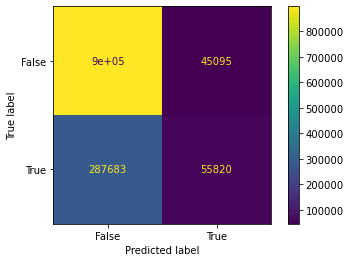

In [116]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(log_incr, X_test, y_test)

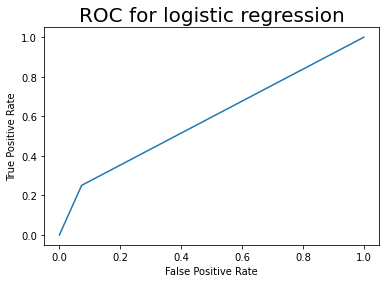

In [78]:
fpr, tpr, _ = metrics.roc_curve(y_test,  predictions_incr)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC for logistic regression", fontsize=20)
plt.show()

# SVM

In [89]:
from sklearn.svm import SVC
print("SVM with Cross-Validation")
svm = SVC()
#para = {"kernel":("linear", "poly", "rbf")}
#para = {"kernel":("linear")}
#svm_DS = GridSearchCV(svm, para, cv = 3, verbose=1)

#sample_Xtrain = X_train.sample(frac=0.001)
#sample_ytrain = pd.DataFrame(y_train).sample(frac=0.001)



svm.fit(sX_train, sy_train.values.ravel())

pred_svm = svm.predict(sX_test)
#svm_DS.best_estimator_

SVM with Cross-Validation


In [90]:
from sklearn import metrics
print('1. Accuracy:', metrics.accuracy_score(sy_test, pred_svm ))
print('2. Precision:', metrics.precision_score(sy_test, pred_svm ))
print('3. Recall:', metrics.recall_score(sy_test, pred_svm))
print('4. F1 Score:', metrics.f1_score(sy_test, pred_svm ))

1. Accuracy: 0.7366465397120298
2. Precision: 0.5976027397260274
3. Recall: 0.09926052332195677
4. F1 Score: 0.17024390243902437


/Users/yun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


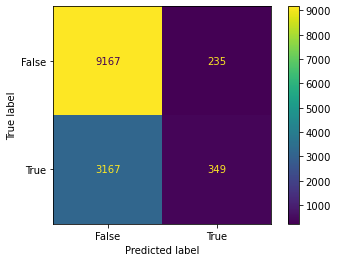

In [93]:
plot_confusion_matrix(svm, sX_test, sy_test)

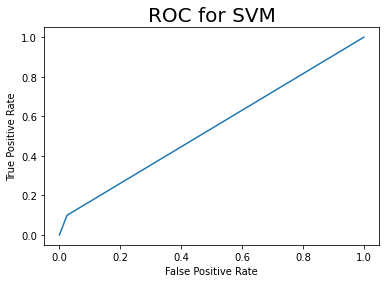

In [91]:
fpr, tpr, _ = metrics.roc_curve(sy_test,  pred_svm )

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC for SVM", fontsize=20)
plt.show()

# KNN

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
neigh=KNeighborsClassifier()
para = {"n_neighbors":([3,5,7])}
#para = {"kernel":("linear")}
knn = GridSearchCV(neigh,para, cv = 3, verbose=1)
knn.fit(sX_train, sy_train)

pred_knn = knn.predict(sX_test)
knn.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


KNeighborsClassifier(n_neighbors=7)

In [95]:
print('1. Accuracy:', metrics.accuracy_score(sy_test, pred_knn ))
print('2. Precision:', metrics.precision_score(sy_test, pred_knn ))
print('3. Recall:', metrics.recall_score(sy_test, pred_knn))
print('4. F1 Score:', metrics.f1_score(sy_test, pred_knn ))

1. Accuracy: 0.7310729215048769
2. Precision: 0.5092348284960422
3. Recall: 0.3293515358361775
4. F1 Score: 0.4


/Users/yun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


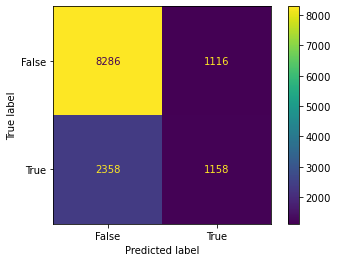

In [96]:
#from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn, sX_test, sy_test)

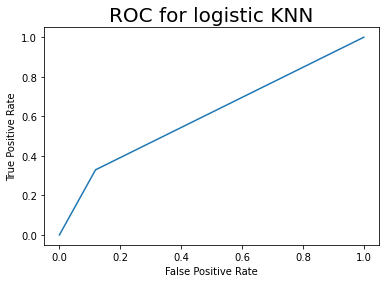

In [97]:
fpr, tpr, _ = metrics.roc_curve(sy_test,  pred_knn )

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC for logistic KNN", fontsize=20)
plt.show()

# Gradient Boosting Classifier

In [26]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

In [117]:
gdbt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)

gdbt.fit(X_train, y_train)

predictions_gdbt = gdbt.predict(X_test)

In [118]:
print('1. Accuracy:', metrics.accuracy_score(y_test, predictions_gdbt ))
print('2. Precision:', metrics.precision_score(y_test, predictions_gdbt ))
print('3. Recall:', metrics.recall_score(y_test, predictions_gdbt))
print('4. F1 Score:', metrics.f1_score(y_test, predictions_gdbt ))

1. Accuracy: 0.8965657381972748
2. Precision: 0.9314148858076713
3. Recall: 0.6611849095932204
4. F1 Score: 0.7733737864904162


/Users/yun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


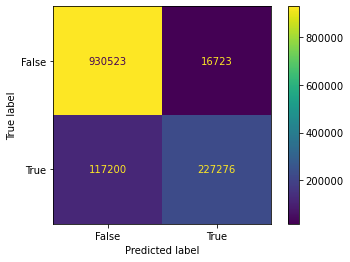

In [85]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gdbt, X_test, y_test)

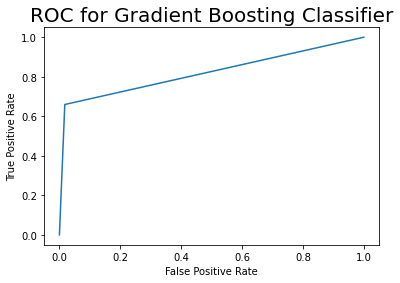

In [86]:
fpr, tpr, _ = metrics.roc_curve(y_test,  predictions_gdbt )

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC for Gradient Boosting Classifier", fontsize=20)
plt.show()

Text(0, 0.5, 'Mean decrease in impurity')

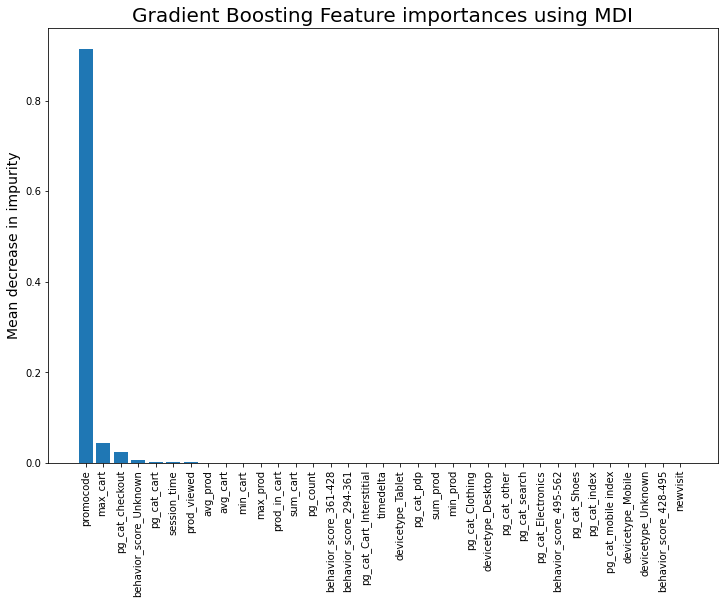

In [126]:
plt.figure(figsize=(12,8))
sorted_idx = gdbt.feature_importances_.argsort()[::-1]
plt.bar(X_train.columns[sorted_idx], gdbt.feature_importances_[sorted_idx])
plt.xticks(rotation=90)
plt.title("Gradient Boosting Feature importances using MDI", fontsize=20)
plt.ylabel("Mean decrease in impurity", fontsize=14)


In [127]:
from sklearn.neural_network import MLPClassifier

In [168]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(16, 16), random_state=1)
clf.fit(X_train, y_train)
predictions_NN = clf.predict(X_test)

/Users/yun/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [169]:
print('1. Accuracy:', metrics.accuracy_score(y_test, predictions_NN ))
print('2. Precision:', metrics.precision_score(y_test, predictions_NN ))
print('3. Recall:', metrics.recall_score(y_test, predictions_NN))
print('4. F1 Score:', metrics.f1_score(y_test, predictions_NN ))

1. Accuracy: 0.7331268916802978
2. Precision: 0.5862944162436549
3. Recall: 0.0006724832097536266
4. F1 Score: 0.0013434255024033356


/Users/yun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


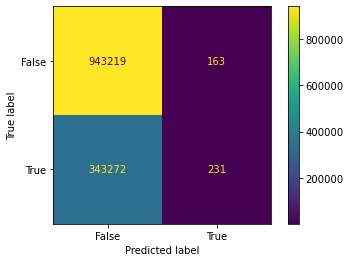

In [170]:
plot_confusion_matrix(clf, X_test, y_test)

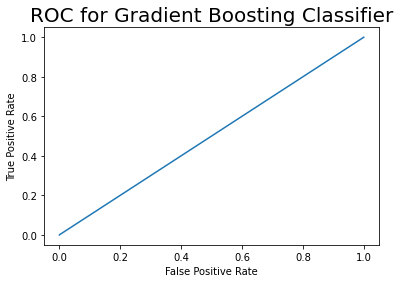

In [171]:
fpr, tpr, _ = metrics.roc_curve(y_test,  predictions_NN )

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC for Gradient Boosting Classifier", fontsize=20)
plt.show()